In [48]:
"""
https://irbank.net/download
からcsvデータを取得して、決算情報等を更新して学習するときに便利なようにするprogram
"""
import os
# os.makedirs(new_dir_path_recursive, exist_ok=True)
import sys
from datetime import datetime,timedelta
import pandas as pd
import  numpy as np
import subprocess
from tqdm import tqdm
#science  ----------------
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
from scipy.integrate._ivp.radau import P
# from scipy.integrate._ivp.radau import P
from sklearn.preprocessing import MinMaxScaler
import time
import warnings 
warnings.simplefilter("ignore")

# stock module ----------------
HOME="/home/ysorimachi/work/sori_py2/analysis_stock"
sys.path.append(f"{HOME}/py")
from utils_data import check_cate, get_stock

# gluont-ts module import  ----------------
# check_cate()
check_cate("name17")
check_cate("name33")
check_cate('market')
# -----------------

--------------- name17 ---------------
['食品(137)', '-(345)', '商社・卸売(317)', '建設・資材(311)', '鉄鋼・非鉄(79)', 'エネルギー資源(17)', '情報通信・サービスその他(1133)', '機械(230)', '医薬品(72)', '不動産(142)', '運輸・物流(119)', '金融（除く銀行）(89)', '小売(343)', '素材・化学(289)', '電機・精密(293)', '自動車・輸送機(110)', '銀行(81)', '電力・ガス(24)']
--------------- name33 ---------------
['水産・農林業(12)', '-(345)', '卸売業(317)', '建設業(165)', '非鉄金属(36)', '鉱業(6)', 'サービス業(503)', '機械(230)', '金属製品(90)', '情報・通信業(518)', '食料品(125)', '医薬品(72)', '不動産業(142)', '陸運業(62)', 'その他金融業(33)', '小売業(343)', 'その他製品(112)', '繊維製品(51)', '電気機器(243)', 'ガラス・土石製品(56)', '証券、商品先物取引業(41)', '輸送用機器(91)', '石油・石炭製品(11)', '化学(214)', 'パルプ・紙(24)', '精密機器(50)', 'ゴム製品(19)', '鉄鋼(43)', '銀行業(81)', '保険業(15)', '倉庫・運輸関連業(39)', '海運業(13)', '空運業(5)', '電気・ガス業(24)']
--------------- market ---------------
['市場第一部（内国株）(2189)', 'ETF・ETN(274)', 'JASDAQ(スタンダード・内国株）(656)', 'JASDAQ(グロース・内国株）(37)', 'マザーズ（内国株）(380)', 'PROMarket(49)', '市場第二部（内国株）(470)', '市場第一部（外国株）(1)', 'REIT・ベンチャーファンド・カントリーファンド・インフラファンド(69)', 'JASDAQ(スタンダード

Index(['code', '年度', '総資産', '純資産', '株主資本', '利益剰余金', '短期借入金', '長期借入金', 'BPS',
       '自己資本比率', '営業CF', '投資CF', '財務CF', '設備投資', '現金同等物', '営業CFマージン', '売上高',
       '営業利益', '経常利益', '純利益', 'EPS', 'ROE', 'ROA', '一株配当', '剰余金の配当', '自社株買い',
       '配当性向', '総還元性向', '純資産配当率', 'name'],
      dtype='object')


100%|██████████| 30/30 [00:00<00:00, 45.20it/s]


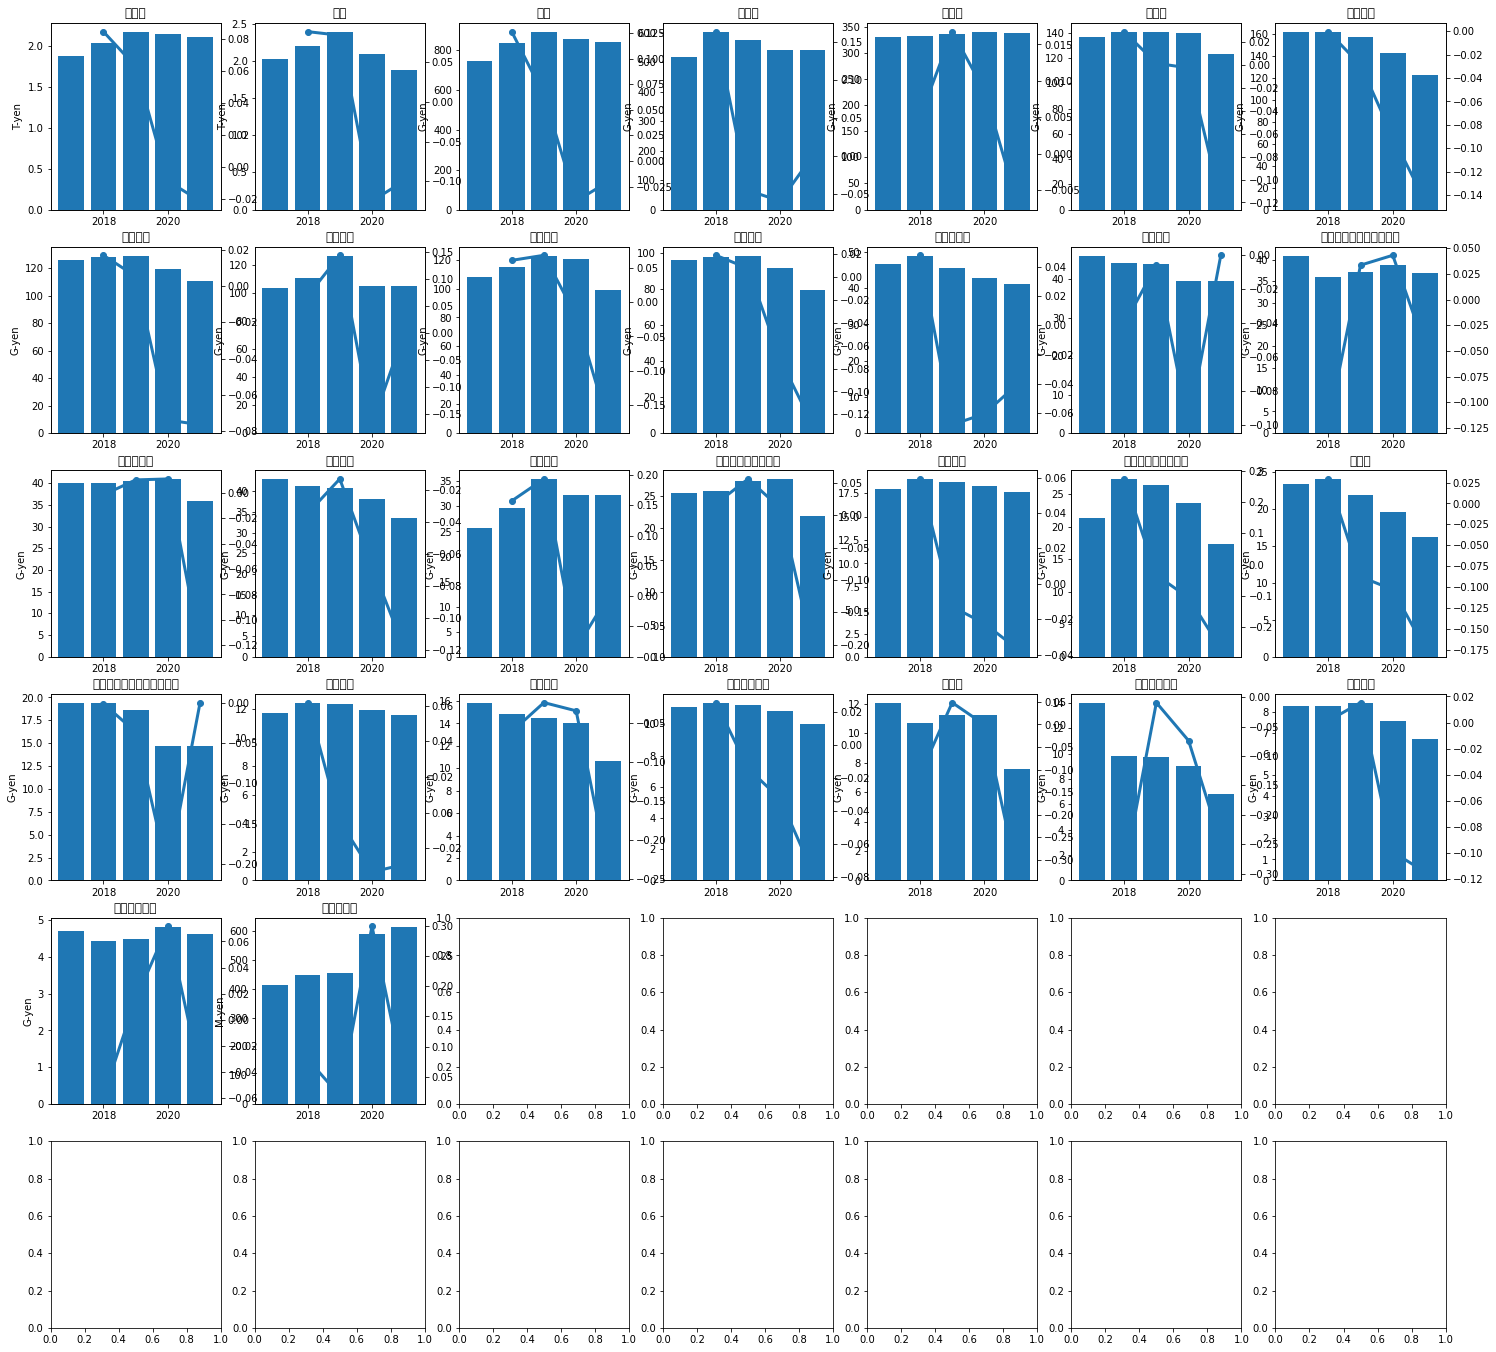

In [51]:
cate="name17"
name = "素材・化学"

def mk_ticker_hash(cate,name):
    _f = sorted(os.listdir(f"../out/ts1/{cate}/{name}"))
    com_hash = { f.split("_")[0][:4] :  f.split(".")[0].split("_")[1] for f in _f}
    return com_hash

def check_benefit(cate,name):
    com_hash = mk_ticker_hash(cate,name)
    
    return

def read_funda(yy):
    path = f"{HOME}/dat/fundamental/origin/master/funda_set_{yy}.csv"
    df = pd.read_csv(path)
    return df

def info_funda(yy):
    path = f"{HOME}/dat/fundamental/origin/master/funda_set_{yy}.csv"
    df = pd.read_csv(path)
#     print(df.shape)
    print(df.columns)
    return
    

def df_funda(cate,name):
    com_hash = mk_ticker_hash(cate,name)
    _code = list(com_hash.keys())
    
    _df = []
    for yy in [2017,2018,2019,2020,2021]:
        df = read_funda(yy)
        df["code"] = df["code"].astype(str)
        df["yy"] = yy
        
        df = df.loc[df["code"].isin(_code),:]
        _df.append(df)
    
    df= pd.concat(_df,axis=0)
    return df


def plot_funda(cate,name,info="売上高"):
    com_hash = mk_ticker_hash(cate,name)
    _code = list(com_hash.keys()) 
    
    # ------------------------------
    if len(_code)<=28:
        f,ax = plt.subplots(4,7,figsize=(25,16))
    else:
        _code = _code[:42]
        f,ax = plt.subplots(6,7,figsize=(25,24))
    ax = ax.flatten()
    # ------------------------------
    df = df_funda(cate,name)
    
    
    #----------------
    vmax = df[info].max()
    vmin = df[info].min()
#     print(vmax)
#     print(vmin)
#     sys.exit()
    
    
    use_col = ['code',"yy","name",'年度'] + [info]
    df = df[use_col]
    df2  = df[df["yy"]==2021].sort_values(info,ascending=False)
#     print(df2.head())
#     sys.exit()
    _code= list(df2["code"].values)
#     print(_code)
#     sys.exit()
    for (i,code) in tqdm(list(enumerate(_code))):
#         print(code)
        tmp = df[df["code"]==code]
        tmp["pct_shange"] = tmp[info].pct_change()
        
        name = tmp["name"].values[0]
        vmax = tmp[info].max()
#         vmin = df[info].min()

        #1000 = K-yen(千円)
        #1000000 = M-yen(百万円)
        #1000000000 = G-yen(10億円)
        #1000000000000 = T-yen(1兆円)
        if vmax > 1e12:
            tmp[info] /= 1e12
            ylabel = "T-yen"
        elif vmax > 1e9:
            tmp[info] /= 1e9
            ylabel = "G-yen"
        elif vmax > 1e6:
            tmp[info] /= 1e6
            ylabel = "M-yen" 
        elif vmax > 1e3:
            tmp[info] /= 1e3
            ylabel = "K-yen"
        else:
            ylabel = "1-yen"
        
        
        ax[i].bar(tmp["yy"],tmp[info])
        bx = ax[i].twinx()
        bx.plot(tmp["yy"],tmp["pct_shange"],marker="o",lw=3)
        ax[i].set_title(tmp["name"].values[0])
        ax[i].set_ylabel(ylabel)
        
        ax[i].set_title(name)

    plt.show()
    return
    

#-------------
# get_stock(cate,name,n=30) # get _data
# df = df_funda(cate,name)
info_funda(2021)
plot_funda(cate,name)